# Systematic Literature Review DX in Shipping - Citation and Co-citation analysis

Note: We can only do thematic analysis on title, since for the abstract we have inverted abstract and we are not capable of properly rebulding it

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain  # Correct import
# import json
# import numpy as np
# from collections import Counter

# import spacy
# from spacy.lang.en.stop_words import STOP_WORDS
# from spacy.tokens import DocBin

# from gensim import corpora
# from gensim.models import LdaModel
# from sklearn.feature_extraction.text import TfidfVectorizer

# from transformers import BertTokenizer, BertModel
# import torch
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA

## Read the DB in

In [3]:
# Read in the file
#lit = pd.read_csv('C:/projects/dx_in_shipping/openalex_data_final.csv')
lit = pd.read_csv('./openalex_data.csv',low_memory=False)

In [4]:
# This cell is useful to check columns in the db. To be used only after having loaded the pandas df
substring = 'referenced_works'
# List all column names containing the substring using list comprehension
matching_columns = [k for k in lit.columns if substring in k]
matching_columns.remove('referenced_works_count')
#print(matching_columns)
#print(lit['referenced_works_0'])
#print(lit['id'])

In [5]:
# Let's build the graph of co-citations
node_ids = lit['id'].tolist()
G = nx.Graph()

for index, row in lit.iterrows():
    if not pd.isnull(row['id']):
        for c in matching_columns:
            if not pd.isnull(row[c]):
                # we only want to focus on co-citations when it comes to the graph
                if (row[c] in node_ids):
                    G.add_edge(row['id'], row[c])

In [8]:
print(G.number_of_nodes())

1298


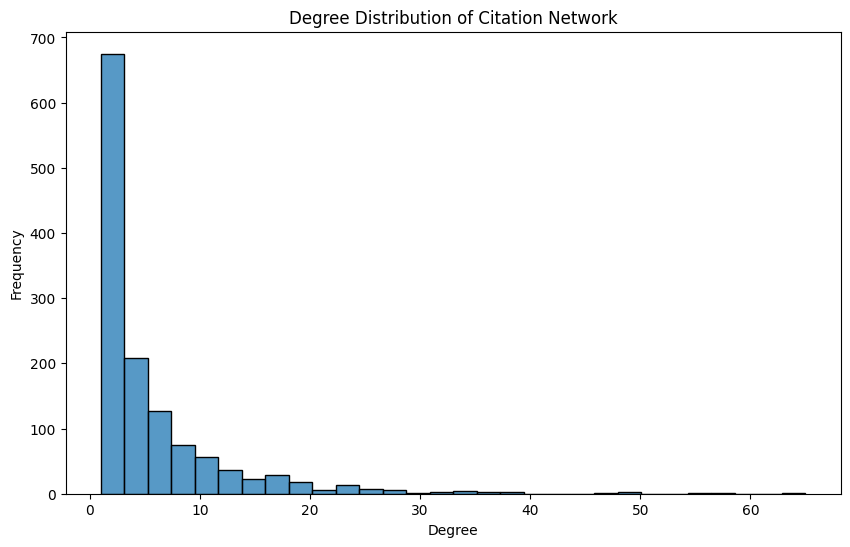

In [11]:
# Assuming G is your citation network graph
# Get a list of all degrees in the network
degrees = [deg for node, deg in G.degree()]

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot the degree distribution as a histogram
sns.histplot(degrees, bins=30, kde=False, stat="count")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution of Citation Network")
plt.show()

In [13]:
# Node degree (number of connections) can represent influence in the network
influential_papers = sorted(G.degree, key=lambda x: x[1], reverse=True)
print("Most influential papers:", influential_papers[:10])

Most influential papers: [('https://openalex.org/W3041382323', 65), ('https://openalex.org/W4399283331', 58), ('https://openalex.org/W2978644098', 55), ('https://openalex.org/W2964482263', 50), ('https://openalex.org/W4400493457', 48), ('https://openalex.org/W4308036928', 46), ('https://openalex.org/W2944924828', 39), ('https://openalex.org/W2917580293', 39), ('https://openalex.org/W4205557186', 38), ('https://openalex.org/W4225993858', 36)]


In [99]:
# Calculate node degree for each node in the network
node_degrees = dict(G.degree())

# Convert node degrees to a DataFrame for easier manipulation
degree_df = pd.DataFrame(list(node_degrees.items()), columns=['node', 'degree'])

# Set percentage of top nodes to keep (e.g., top 10%)
top_percentage = 0.20
num_nodes_to_keep = int(len(degree_df) * top_percentage)

# Sort by degree in descending order and select the top nodes
top_nodes = degree_df.sort_values(by='degree', ascending=False).head(num_nodes_to_keep)['node']

# Create a subgraph with only the top connected nodes
G_top = G.subgraph(top_nodes)

# we want toc consider only the largest connected component
connected_components = list(nx.connected_components(G_top))

# Step 2: Get the largest connected component (max by length)
largest_component = max(connected_components, key=len)

# Step 3: Create a subgraph of the largest connected component
G_lcc = G_top.subgraph(largest_component).copy()

print(G.number_of_nodes())
print(G_top.number_of_nodes())
print(G_lcc.number_of_nodes())


1298
259
257


In [77]:
top_nodes

188     https://openalex.org/W3041382323
1062    https://openalex.org/W4399283331
125     https://openalex.org/W2978644098
24      https://openalex.org/W2964482263
1036    https://openalex.org/W4400493457
                      ...               
650     https://openalex.org/W4400650555
857     https://openalex.org/W4200204151
635     https://openalex.org/W2002507421
862     https://openalex.org/W4387321456
565     https://openalex.org/W4396227246
Name: node, Length: 519, dtype: object

In [101]:
# Let's create communities

# Step 1: Apply Louvain method for community detection
partition = community_louvain.best_partition(G_lcc)

# Step 2: Visualize the graph with community colors
values = [partition.get(node) for node in G_lcc.nodes()]

# Step 4: Create a force-directed layout
pos = nx.spring_layout(G_lcc, k=0.15, iterations=100)

In [153]:
# Get unique communities and map them to colors
unique_communities = set(values)
community_colors = {community: plt.cm.rainbow(i / len(unique_communities)) for i, community in enumerate(unique_communities)}

# Step 4: Create a list of handles and labels for the legend
handles = []
labels = []
for community, color in community_colors.items():
    # Create a patch for the legend with each community's color
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10))
    labels.append(f"Community {community}")

# Step 4: Display community-color mapping
print("Community to Color Mapping:")
for community, color in community_colors.items():
    print(f"Community {community}: {color}")

Community to Color Mapping:
Community 0: (0.5, 0.0, 1.0, 1.0)
Community 1: (0.24901960784313726, 0.38410574917192586, 0.9806347704689777, 1.0)
Community 2: (0.0019607843137254832, 0.7092813076058535, 0.9232891061054894, 1.0)
Community 3: (0.2529411764705882, 0.9256376597815562, 0.8301840308155507, 1.0)
Community 4: (0.503921568627451, 0.9999810273487268, 0.7049255469061472, 1.0)
Community 5: (0.7549019607843137, 0.9209055179449537, 0.5523649729605058, 1.0)
Community 6: (1.0, 0.7005430375932911, 0.37841105004231035, 1.0)
Community 7: (1.0, 0.37270199199091436, 0.18980109344182594, 1.0)


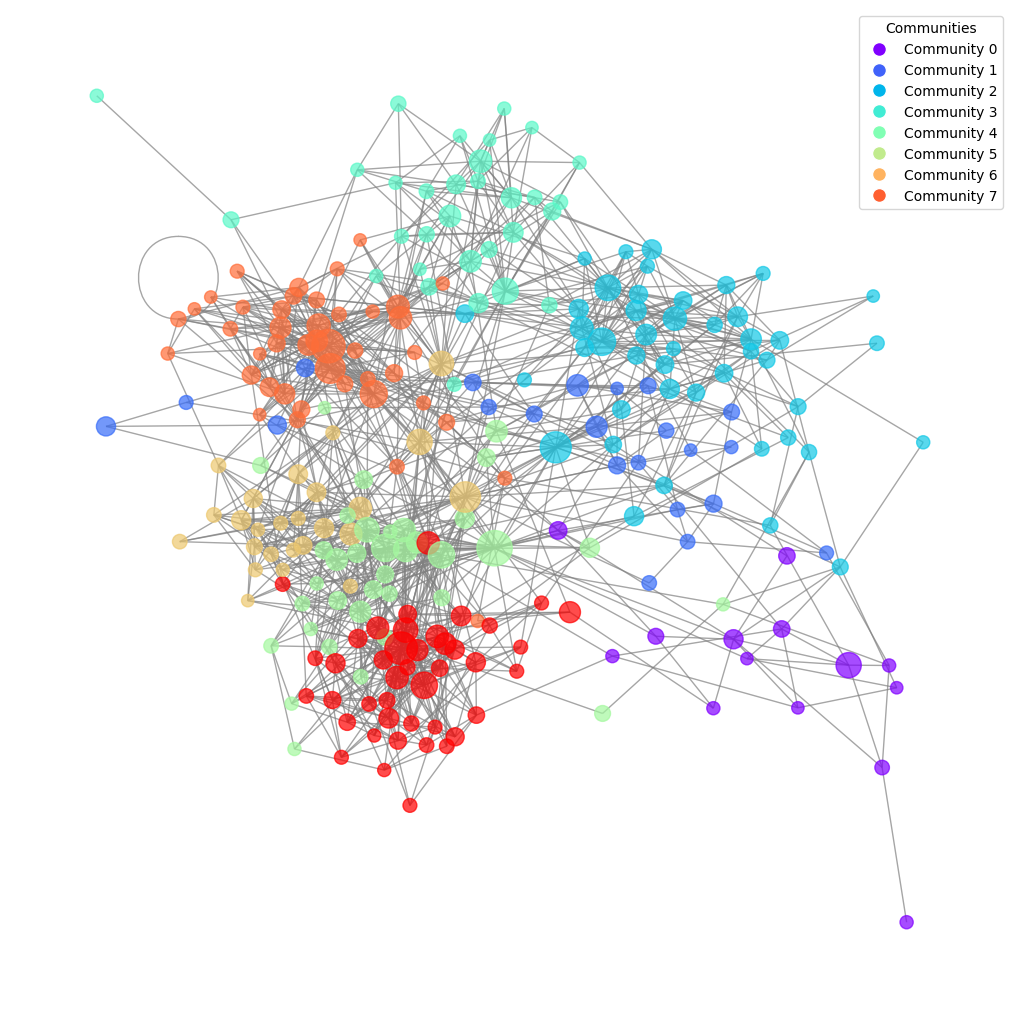

In [155]:
# Visualize the co-citation network

# Scale node sizes based on their degree in the original graph (before filtering)
node_sizes = [node_degrees[node] * 10 for node in G_lcc.nodes()]  # Multiply by 10 for visibility

plt.figure(figsize=(10, 10))  # Optional: Adjust figure size
nx.draw(G_lcc, pos, with_labels=False, node_size=node_sizes, node_color=values, cmap=plt.cm.rainbow, font_size=10, font_weight='bold', edge_color='gray', alpha=0.7)
# Add legend
plt.legend(handles=handles, labels=labels, title="Communities", loc="best", fontsize=10)
plt.show()

In [131]:
partition # this is a dictionary: the key is the article openalex id, and the value is the partition.

# we now collect the corresponding titles and link titles to partitions

partition_titles = {}
for k, v in partition.items():
    lit_f = lit[lit['id'] == k]
    if (len(lit_f)> 0):
        if v not in partition_titles:
            partition_titles[v] = [lit_f['title'].iloc[0]]
        else:
            partition_titles[v].append(lit_f['title'].iloc[0])
    else:
        print('not found')

['Spatial Modeling of Maritime Risk Using Machine Learning', 'Trends of digitalization, intelligence and greening of global shipping industry based on CiteSpace Knowledge Graph', 'Intelligent ship collision avoidance in maritime field: A bibliometric and systematic review', 'Research on ship safety risk early warning model integrating transfer learning and multi-modal learning', 'A machine learning approach for monitoring ship safety in extreme weather events', 'A concept of critical safety area applicable for an obstacle-avoidance process for manned and autonomous ships', 'A systematic analysis for maritime accidents causation in Chinese coastal waters using machine learning approaches', 'Analysis of factors affecting the severity of marine accidents using a data-driven Bayesian network', 'Development of an Interpretable Maritime Accident Prediction System Using Machine Learning Techniques', 'A human-centred review on maritime autonomous surfaces ships: impacts, responses, and future 

In [147]:
# Next we use chatgpt to summarize the titles in each partition as one topic
print(partition_titles[7])

['Blockchain technology investment strategy for shipping companies under competition', 'How TradeLens Delivers Business Value With Blockchain Technology', 'Blockchain-Powered Incentive System for JIT Arrival Operations and Decarbonization in Maritime Shipping', 'Blockchain adoption strategy of two-sided shipping platforms connecting forwarder and liner company', 'Blockchain implementation in the maritime industry: critical success factors and strategy formulation', 'Blockchain technology for port logistics capability: Exclusive or sharing', 'Blockchain Technology and Sustainability in Supply Chains and a Closer Look at Different Industries: A Mixed Method Approach', 'Blockchain technology in maritime supply chains: applications, architecture and challenges', 'A Review of Blockchain Technology Implementation in Shipping Industry', 'Analysing the intention to use blockchain technology in payment transactions of Turkish maritime industry', 'Consortium blockchain in Shipping: Impacts on in

## Next we use chatgpt to summarize the titles in each partition as one topic

### partition 0
The common theme across the research papers you provided is optimization and prediction of fuel consumption,
energy efficiency, and environmental impact in the maritime industry,
with a focus on machine learning, big data, and modeling techniques.

### partition 1
The common theme across these research papers is maritime safety, risk management, and the application of machine learning techniques to predict, analyze, and mitigate accidents and hazards in maritime operations. It also explores the intersection of autonomous ships, human factors, and intelligent systems in improving maritime safety.

### partition 2
The common theme across these research papers is machine learning, artificial intelligence, and big data applications in the maritime domain, with a focus on predictive analytics, vessel trajectory prediction, fuel consumption estimation, traffic management, cybersecurity, and autonomous ship operations.

### partition 3
The common theme across these research papers is the integration of Internet of Things (IoT), mobile edge computing, communication networks, and security within the maritime industry, with a particular focus on autonomous ships, data offloading, latency minimization, and communication technologies for maritime transportation systems.

### partition 4
The common theme across these research papers is the digital transformation and technological advancements within the maritime sector, particularly in relation to maritime logistics, container shipping, port operations, and the broader shipping supply chain. These studies explore the integration of digital twins, Industry 4.0 technologies, big data, IoT, machine learning, and artificial intelligence in improving efficiency, sustainability, and safety in maritime operations.

### partition 5
The common theme across these research papers revolves around the development and optimization of smart ports, focusing on the integration of Industry 4.0 technologies such as IoT, AI, big data, and blockchain. These studies emphasize how digitalization, automation, and energy efficiency are transforming port operations to make them more sustainable, efficient, and resilient in the face of global challenges. The research also explores the cybersecurity risks and sustainability efforts associated with green ports and smart infrastructure.

### partition 6
The common theme across these research papers is focused on maritime cybersecurity, with an emphasis on cyber risks associated with the digital transformation of the maritime industry, particularly as it pertains to the rise of autonomous vessels, smart shipping technologies, and the IoT-enabled maritime environment. These studies explore the vulnerabilities and cybersecurity challenges in both ports and ships, proposing various cyber risk assessments, threat modeling, and countermeasures to address emerging cyber threats. The papers also examine regulatory frameworks, cyber resilience training, and the impact of digitalization on ship systems, highlighting the need for proactive cybersecurity management.

### partition 7
The focus of these papers is on the adoption and application of blockchain technology in the maritime industry, specifically in areas like shipping, supply chains, and port management. The studies explore how blockchain can enhance efficiency, transparency, and sustainability within maritime logistics, including smart contracts, traceability, and decarbonization efforts. Key topics include investment strategies, barriers to adoption, collaborative platforms, and the impact of blockchain on shipping operations. These studies also examine technical sustainability, policy implications, and the business value of integrating blockchain in maritime logistics, highlighting the challenges and future potential of this transformative technology.

In [167]:
# Now we use centrality over the global graph to find the most influencial papers
# Calculate centrality
# Calculate Degree Centrality
degree_centrality = nx.degree_centrality(G)

# Calculate Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G, normalized=True)

# Calculate Closeness Centrality
closeness_centrality = nx.closeness_centrality(G)

# Calculate Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# Calculate PageRank
pagerank = nx.pagerank(G)


# Visualize with node size based on centrality
# plt.figure(figsize=(10, 8))
# nx.draw(G, with_labels=False, node_size=[v * 1000 for v in centrality.values()])
# plt.show()

In [169]:
# Display the top 5 nodes for each centrality measure
print("Top 5 nodes by Degree Centrality:")
print(sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

print("\nTop 5 nodes by Betweenness Centrality:")
print(sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

print("\nTop 5 nodes by Closeness Centrality:")
print(sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

print("\nTop 5 nodes by Eigenvector Centrality:")
print(sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

print("\nTop 5 nodes by PageRank:")
print(sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5])

Top 5 nodes by Degree Centrality:
[('https://openalex.org/W3041382323', 0.05011565150346954), ('https://openalex.org/W4399283331', 0.044718581341557435), ('https://openalex.org/W2978644098', 0.04240555127216654), ('https://openalex.org/W2964482263', 0.03855050115651503), ('https://openalex.org/W4400493457', 0.03700848111025443)]

Top 5 nodes by Betweenness Centrality:
[('https://openalex.org/W3041382323', 0.11878184093636855), ('https://openalex.org/W4400493457', 0.0862369578746974), ('https://openalex.org/W2964482263', 0.07669997543402837), ('https://openalex.org/W4386245296', 0.050334142047570585), ('https://openalex.org/W4205557186', 0.0418721600603818)]

Top 5 nodes by Closeness Centrality:
[('https://openalex.org/W3041382323', 0.3261451499654046), ('https://openalex.org/W4400493457', 0.31977663520276656), ('https://openalex.org/W4386245296', 0.3132884136189423), ('https://openalex.org/W2964482263', 0.31049842774643804), ('https://openalex.org/W4225993858', 0.3027577106401543)]

To